In [1]:
#Modelo LSTM para pronosticar la Inflación Subyacente
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
from matplotlib import pylab, mlab, pyplot
from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs
from pylab import *
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
from scipy.stats import randint
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf
import torch
from captum.attr import IntegratedGradients
#Todos los títulos en times new roman
plt.rc('font', family='Times New Roman')
#



In [2]:
#
# Lectura de los datos
#
dataset = pd.read_excel('IPC_LSTM.xlsx',sheet_name='INPCSUB', index_col='fecha', parse_dates=['fecha'])
dataset=dataset.resample('M').last()
dataset.head()



,ipcsub
fecha,
1989-01-31,6.900670
1989-02-28,7.039663
1989-03-31,7.136210
1989-04-30,7.222918
1989-05-31,7.298140


In [4]:
#Veamos la descripción de los datos
descripcion1=pd.DataFrame(dataset.describe())
descripcion1
descripcion1.to_csv('descripciondatos.csv')


In [3]:
descripcion1=pd.DataFrame(dataset.describe())
descripcion1

,ipcsub
count,411.000000
mean,62.059312
std,32.978087
min,6.900670
25%,34.237861
50%,64.104561
75%,87.573317
max,127.712394


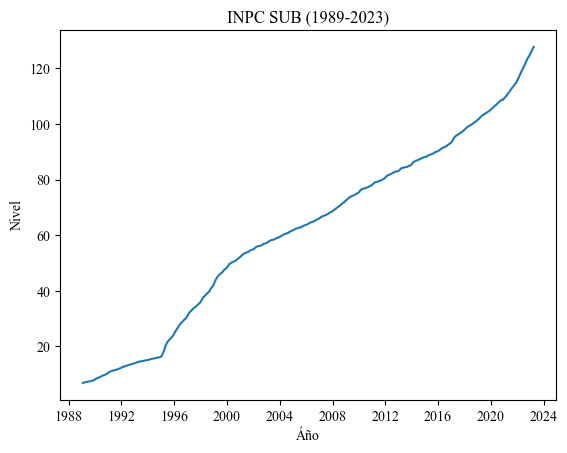

In [3]:
#Visualizamos los datos
TN= 'Times New Roman'
plt.figure()
plt.plot(dataset)
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC SUB (1989-2023)', fontname=TN)
for i in plt.get_fignums():
    plt.figure(i)
    plt.savefig('figure%d.png' % i)
plt.show()



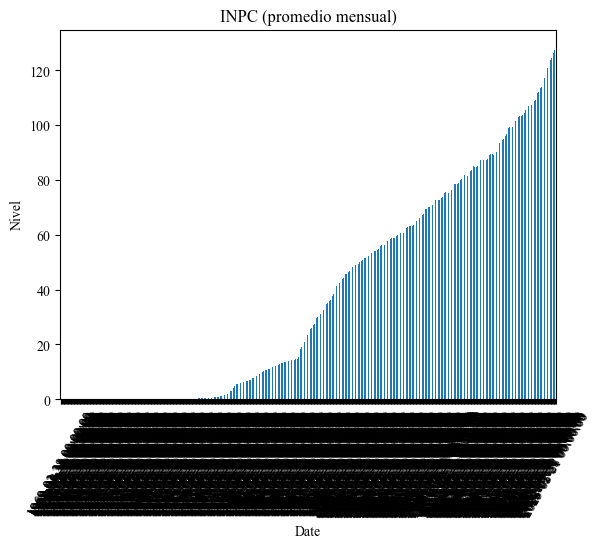

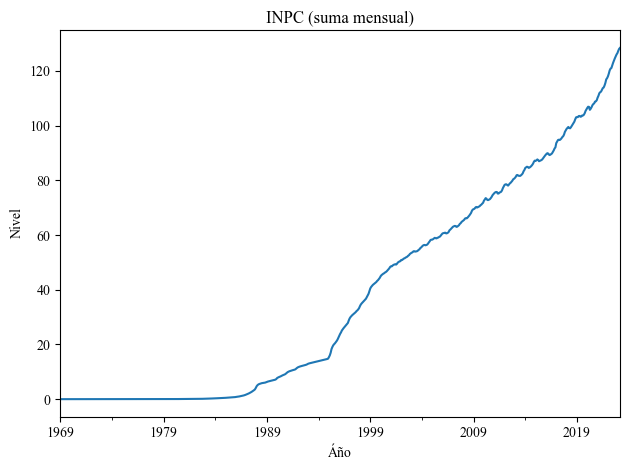

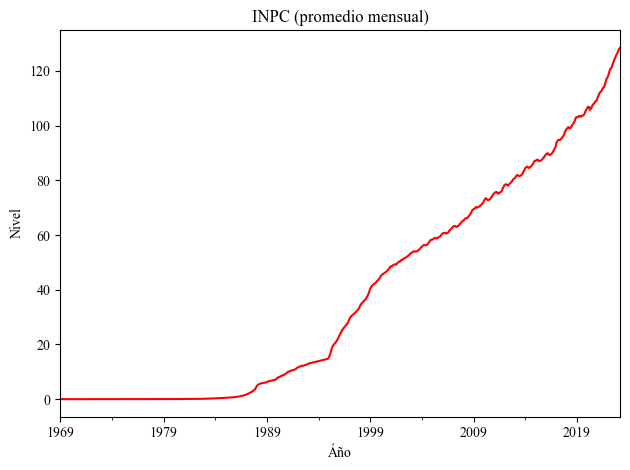

In [6]:
#Promedio mensual
dataset['INPC'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Nivel', fontname=TN)
plt.title('INPC (promedio mensual)', fontname=TN)
plt.show()
#Visualizamos la suma y el promedio
dataset.INPC.resample('M').sum().plot()
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC (suma mensual)', fontname=TN)
plt.tight_layout()
plt.show()
dataset.INPC.resample('M').mean().plot(color='red') 
plt.ylabel('Nivel', fontname=TN)
plt.xlabel('Áño', fontname=TN)
plt.title('INPC (promedio mensual)', fontname=TN)
plt.tight_layout()
plt.show()




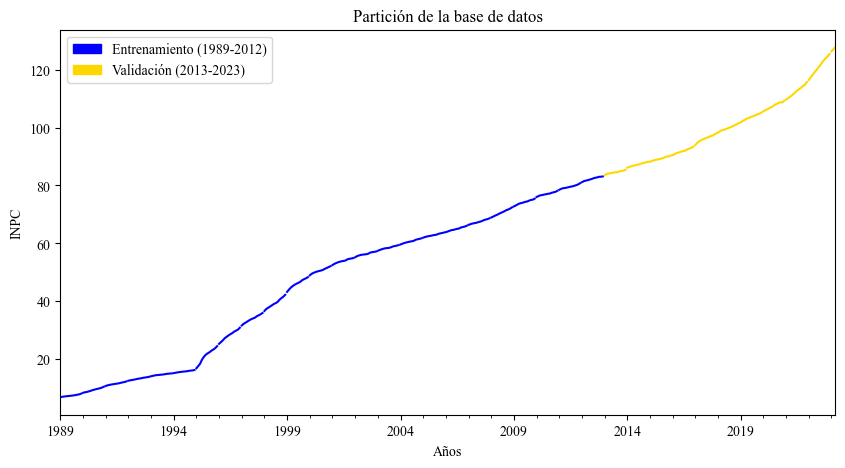

In [4]:
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 1989-2012. La validación se hará con datos de 2013-2023(enero).
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#
set_entrenamiento = dataset['1989':'2012']
set_validacion = dataset['2013':]
#Visualizamos la partición
plt.figure(figsize=(10, 5))
Entrenamiento = mpatches.Patch(color='blue', label='Entrenamiento (1989-2012)')
Prueba = mpatches.Patch(color='gold', label='Validación (2013-2023)')
set_entrenamiento.resample('Y').plot(color='blue')
set_validacion.resample('Y').plot(color='gold')
plt.legend(handles=[Entrenamiento,Prueba],loc='best')
plt.ylabel('INPC', fontname=TN)
plt.xlabel('Años', fontname=TN)
plt.title('Partición de la base de datos', fontname=TN)
plt.show()



In [5]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 3
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reshape X_train para que se ajuste al modelo en Keras
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [6]:
#Ahora vamos a darle forma al set de prueba
set_validacion_escalado = sc.fit_transform(set_validacion)
m = len(set_validacion_escalado)
x_test = []
y_test = []
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    x_test.append(set_validacion_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    y_test.append(set_validacion_escalado[i,0])
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape x_test para que se ajuste al modelo en Keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [7]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 120

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada, return_sequences=True))
modelo.add(LSTM(units=80, input_shape=dim_entrada, return_sequences=False))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='adam', loss='mse')
hist = modelo.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False)




Epoch 1/100
9/9 - 4s - loss: 0.2447 - val_loss: 0.0934 - 4s/epoch - 425ms/step
Epoch 2/100
9/9 - 0s - loss: 0.0531 - val_loss: 0.0176 - 79ms/epoch - 9ms/step
Epoch 3/100
9/9 - 0s - loss: 0.0273 - val_loss: 0.0318 - 91ms/epoch - 10ms/step
Epoch 4/100
9/9 - 0s - loss: 0.0244 - val_loss: 0.0110 - 82ms/epoch - 9ms/step
Epoch 5/100
9/9 - 0s - loss: 0.0135 - val_loss: 0.0075 - 79ms/epoch - 9ms/step
Epoch 6/100
9/9 - 0s - loss: 0.0072 - val_loss: 0.0055 - 79ms/epoch - 9ms/step
Epoch 7/100
9/9 - 0s - loss: 0.0061 - val_loss: 0.0021 - 63ms/epoch - 7ms/step
Epoch 8/100
9/9 - 0s - loss: 0.0031 - val_loss: 8.6897e-04 - 78ms/epoch - 9ms/step
Epoch 9/100
9/9 - 0s - loss: 0.0020 - val_loss: 4.6131e-04 - 79ms/epoch - 9ms/step
Epoch 10/100
9/9 - 0s - loss: 0.0027 - val_loss: 5.9270e-04 - 79ms/epoch - 9ms/step
Epoch 11/100
9/9 - 0s - loss: 0.0021 - val_loss: 7.4101e-04 - 79ms/epoch - 9ms/step
Epoch 12/100
9/9 - 0s - loss: 0.0026 - val_loss: 5.5182e-04 - 63ms/epoch - 7ms/step
Epoch 13/100
9/9 - 0s - loss

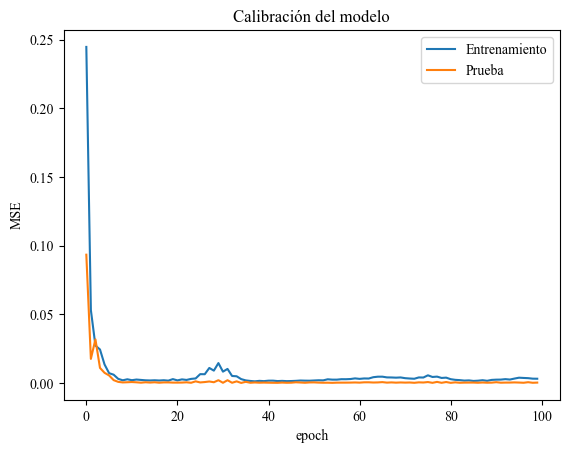

In [8]:
#Visualizar la perdida en función de los epochs
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Calibración del modelo')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper right')
plt.show()


In [9]:
#Predicción de 2022
prediccion = modelo.predict(x_test)
prediccion = sc.inverse_transform(prediccion)
prediction = np.concatenate(prediccion, axis=0 ).tolist()
prediction = [item for sublist in prediccion for item in sublist]
prediction = pd.DataFrame(prediction)
rng = pd.date_range('2013-01-01 00:00:00', periods=123, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ipcsub']
prediction.set_index(['Date'], inplace=True)


4/4 [==============================] - 1s 3ms/step


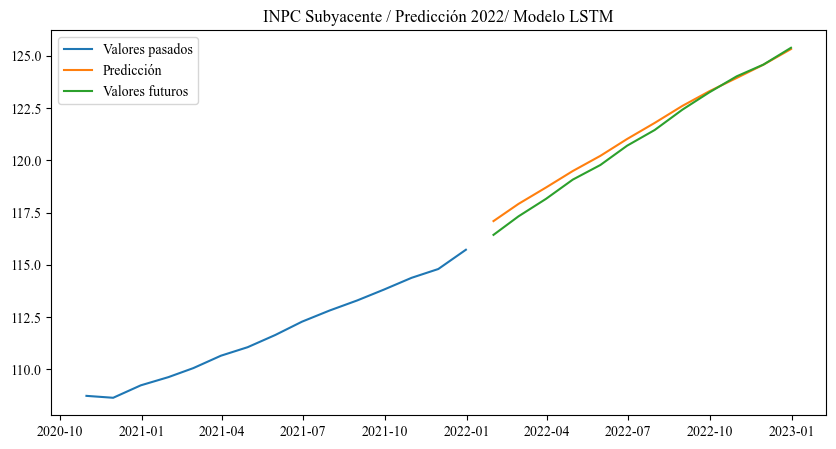

In [10]:
plt.figure(figsize=(10, 5))

item_id = "ipcsub"
y_past = dataset[item_id]
y_pred = prediction[item_id]['2022-01':]
y_test = set_validacion[item_id]['2022-01':'2022-12']

plt.plot(y_past['2020-10':'2021'], label="Valores pasados")
plt.plot(y_pred, label="Predicción")
plt.plot(y_test, label="Valores futuros")
plt.title('INPC Subyacente / Predicción 2022/ Modelo LSTM')

plt.legend();

In [11]:
pd.DataFrame(y_pred)

,ipcsub
Date,
2022-01-31,117.091583
2022-02-28,117.911667
2022-03-31,118.698662
2022-04-30,119.484886
2022-05-31,120.211449
2022-06-30,121.016884
2022-07-31,121.786644
2022-08-31,122.598480
2022-09-30,123.292824


In [12]:
pd.DataFrame(y_test)

,ipcsub
fecha,
2022-01-31,116.432721
2022-02-28,117.316585
2022-03-31,118.155869
2022-04-30,119.074242
2022-05-31,119.774026
2022-06-30,120.696376
2022-07-31,121.447327
2022-08-31,122.417294
2022-09-30,123.239175


In [13]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred['2022-01':'2022-12'])
print('El MSE de la predicción es:', mse)

El MSE de la predicción es: 0.14219020329376525


In [14]:
#Pronóstico de 2008
df=dataset['2008-01':'2009-03']
x_total = df.values
x_total=sc.transform(x_total)
X_total= []
for i in range(time_step,len(x_total)):
    X_total.append(x_total[i-time_step:i,0])
X_total = np.array(X_total)
X_total = np.reshape(X_total, (X_total.shape[0],X_total.shape[1],1))



C:\Users\Erik Rosas\anaconda3\envs\ag\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [15]:
prediccion2= modelo.predict(X_total)
prediccion2 = sc.inverse_transform(prediccion2)
prediction2 = np.concatenate(prediccion2, axis=0 ).tolist()
prediction2 = [item for sublist in prediccion2 for item in sublist]
prediction2 = pd.DataFrame(prediction2)
rng = pd.date_range('2008-01-01 00:00:00', periods=12, freq='M')
rng = pd.DataFrame(rng)
prediction2 = pd.merge(rng, prediction2, left_index=True, right_index=True, how='outer')
prediction2.set_index('0_x')
prediction2.columns = ['Date', 'ipcsub']
prediction2.set_index(['Date'], inplace=True)


1/1 [==============================] - 0s 16ms/step


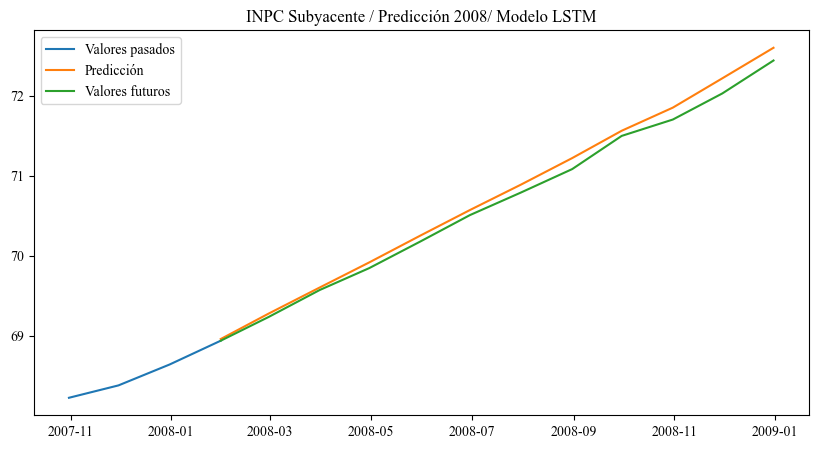

In [16]:
#graficamos el pronóstico de 2008
plt.figure(figsize=(10, 5))

item_id = "ipcsub"
y_past = dataset[item_id]['2007-10':'2008-1']
y_pred = prediction2[item_id]['2008':]
y_test = df[item_id]['2008-01':'2008-12']

plt.plot(y_past, label="Valores pasados")
plt.plot(y_pred, label="Predicción")
plt.plot(y_test, label="Valores futuros")
plt.title('INPC Subyacente / Predicción 2008/ Modelo LSTM')

plt.legend(loc=2);

In [17]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('El MSE de la predicción es:', mse)

El MSE de la predicción es: 0.011153262657156082


In [18]:
#Pronóstico de toda la serie
df1=dataset['1989':'2023']
x_total1 = df1.values
x_total1=sc.transform(x_total1)
X_total1= []
for i in range(time_step,len(x_total1)):
    X_total1.append(x_total1[i-time_step:i,0])
X_total1 = np.array(X_total1)
X_total1 = np.reshape(X_total1, (X_total1.shape[0],X_total1.shape[1],1))



C:\Users\Erik Rosas\anaconda3\envs\ag\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [19]:
prediccion3= modelo.predict(X_total1)
prediccion3 = sc.inverse_transform(prediccion3)
prediction3 = np.concatenate(prediccion3, axis=0 ).tolist()
prediction3 = [item for sublist in prediccion3 for item in sublist]
prediction3 = pd.DataFrame(prediction3)
rng = pd.date_range('1989-01-01 00:00:00', periods=408, freq='M')
rng = pd.DataFrame(rng)
prediction3 = pd.merge(rng, prediction3, left_index=True, right_index=True, how='outer')
prediction3.set_index('0_x')
prediction3.columns = ['Date', 'ipcsub']
prediction3.set_index(['Date'], inplace=True)


13/13 [==============================] - 0s 4ms/step


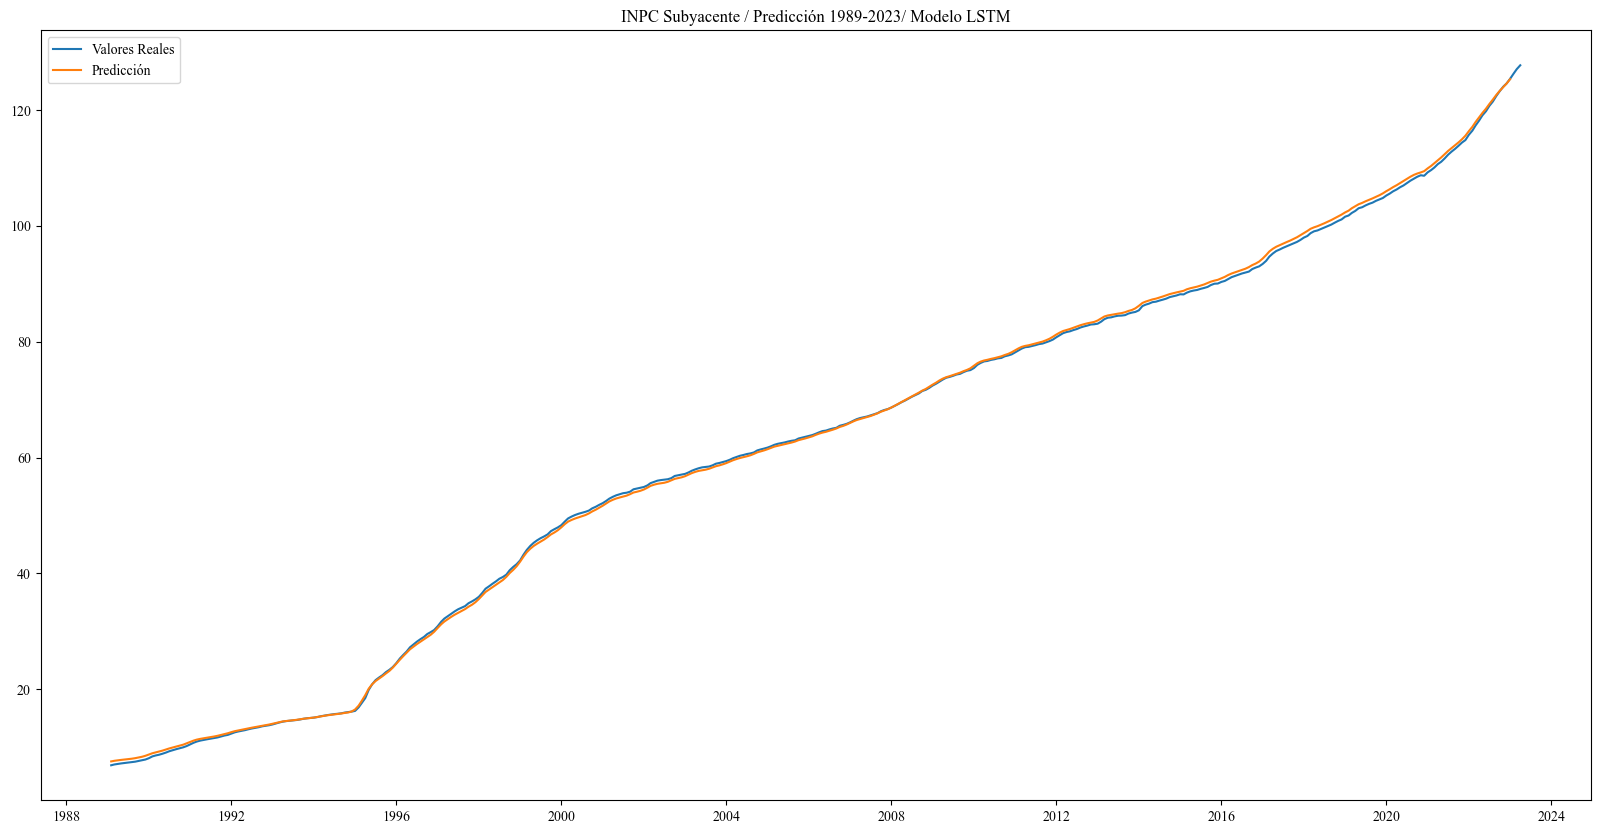

In [21]:
#graficamos el pronóstico de toda la serie
plt.figure(figsize=(20,10))

item_id = "ipcsub"
y_past= df1[item_id]
y_pred = prediction3[item_id]

plt.plot(y_past, label="Valores Reales")
plt.plot(y_pred, label="Predicción")
plt.title('INPC Subyacente / Predicción 1989-2023/ Modelo LSTM')

plt.legend();